In [1]:
pip install torch torchvision numpy matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import models
from collections import Counter
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt

c:\Users\DELL\intelpython3\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Custom Dataset with Albumentations
class AlbumentationsDataset(Dataset):
    def __init__(self, image_folder_dataset, transform=None):
        self.image_folder_dataset = image_folder_dataset
        self.transform = transform

    def __getitem__(self, idx):
        image_path, label = self.image_folder_dataset.samples[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label

    def __len__(self):
        return len(self.image_folder_dataset)



In [ ]:
# Augmentations

def get_train_transforms():
    return A.Compose([
        A.Resize(512, 512),
        A.RandomCrop(448, 448),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussianBlur(blur_limit=3, p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

def get_val_test_transforms():
    return A.Compose([
        A.Resize(448, 448),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

# DataLoader

from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

def create_dataloaders(data_dir, batch_size=16, train_ratio=0.7, val_ratio=0.15):
    raw_dataset = ImageFolder(root=data_dir)
    total_size = len(raw_dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    train_set, val_set, test_set = random_split(raw_dataset, [train_size, val_size, test_size])

    train_dataset = AlbumentationsDataset(train_set.dataset, transform=get_train_transforms())
    val_dataset = AlbumentationsDataset(val_set.dataset, transform=get_val_test_transforms())
    test_dataset = AlbumentationsDataset(test_set.dataset, transform=get_val_test_transforms())

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    print(f"Number of images after augmentation:")
    print(f"Train: {len(train_set)} images")
    print(f"Validation: {len(val_set)} images")
    print(f"Test: {len(test_set)} images")

    return train_loader, val_loader, test_loader, raw_dataset.classes


In [ ]:
class ECALayer(nn.Module):
    def __init__(self, channel, gamma=2, b=1):
        super(ECALayer, self).__init__()
        t = int(abs((torch.log(torch.tensor(channel, dtype=torch.float32)) / torch.log(torch.tensor(2.0))) + b) / gamma)
        k = t if t % 2 else t + 1  
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=(k - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)  # shape: [B, C, 1, 1]
        y = self.conv(y.squeeze(-1).transpose(-1, -2))  # shape: [B, 1, C]
        y = self.sigmoid(y).transpose(-1, -2).unsqueeze(-1)  # shape: [B, C, 1, 1]
        return x * y.expand_as(x)


class CropDiseaseModel(nn.Module):
    def __init__(self, num_classes):
        super(CropDiseaseModel, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        for param in self.backbone.parameters():
            param.requires_grad = True

        self.backbone.fc = nn.Identity()

        self.eca = ECALayer(channel=2048)

        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), 2048, 1, 1)
        x = self.eca(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x



# Plotting Function

def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Acc")
    plt.plot(val_accuracies, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Training Function

def train(model, train_loader, val_loader, epochs=10, lr=0.001, save_path="best_model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_acc)

        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_acc = correct_val / total_val
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"\u2705 Best model saved at epoch {epoch+1} with val acc: {val_acc:.4f}")

        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)



In [ ]:
# 5. MAIN SCRIPT

from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/PFE_dataset_a"

Mounted at /content/drive


✅ Dataset found at: /content/drive/My Drive/PFE_dataset_a
Files: ['Tan Spot', 'Pawdery_mildew', 'Stem', 'Loose Smut', 'Brown', 'Fusarium', 'Septoria', 'Yellow', 'Common Root Rot']


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments o

Number of images after augmentation:
Train: 2486 images
Validation: 532 images
Test: 534 images


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 121MB/s]


✅ Best model saved at epoch 1 with val acc: 0.8339
Epoch [1/25] | Train Loss: 1.5559 | Val Loss: 0.9765 | Train Acc: 0.5318 | Val Acc: 0.8339
✅ Best model saved at epoch 2 with val acc: 0.9313
Epoch [2/25] | Train Loss: 0.9635 | Val Loss: 0.7117 | Train Acc: 0.8257 | Val Acc: 0.9313
✅ Best model saved at epoch 3 with val acc: 0.9645
Epoch [3/25] | Train Loss: 0.8111 | Val Loss: 0.6446 | Train Acc: 0.8854 | Val Acc: 0.9645
✅ Best model saved at epoch 4 with val acc: 0.9772
Epoch [4/25] | Train Loss: 0.7486 | Val Loss: 0.6110 | Train Acc: 0.9093 | Val Acc: 0.9772
✅ Best model saved at epoch 5 with val acc: 0.9820
Epoch [5/25] | Train Loss: 0.7004 | Val Loss: 0.5991 | Train Acc: 0.9338 | Val Acc: 0.9820
✅ Best model saved at epoch 6 with val acc: 0.9848
Epoch [6/25] | Train Loss: 0.6793 | Val Loss: 0.5823 | Train Acc: 0.9445 | Val Acc: 0.9848
✅ Best model saved at epoch 7 with val acc: 0.9885
Epoch [7/25] | Train Loss: 0.6677 | Val Loss: 0.5694 | Train Acc: 0.9462 | Val Acc: 0.9885
Epoch 

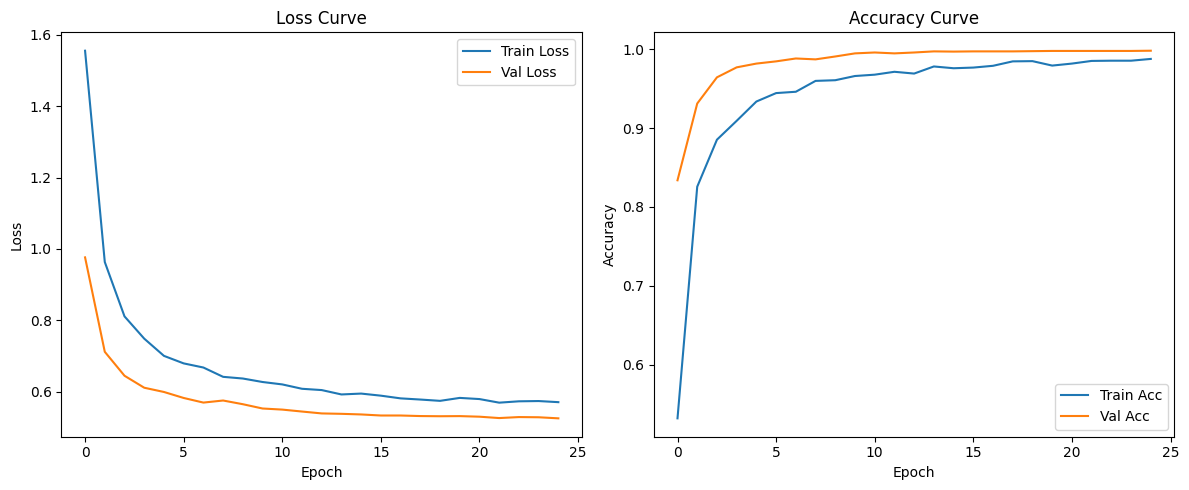

In [8]:
if __name__ == "__main__":
    if os.path.exists(data_path):
        print("✅ Dataset found at:", data_path)
        print("Files:", os.listdir(data_path))
        train_loader, val_loader, test_loader, classes = create_dataloaders(data_path, batch_size=16)
        model = CropDiseaseModel(num_classes=len(classes))
        train(model, train_loader, val_loader, epochs=25, lr=0.001, save_path="best_model.pth")

    else:
        print("❌ Error: Dataset path not found!")

In [9]:
torch.save(model.state_dict(), "M2.pth")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 99.83%
Recall: 0.9978
F1 Score: 0.9981


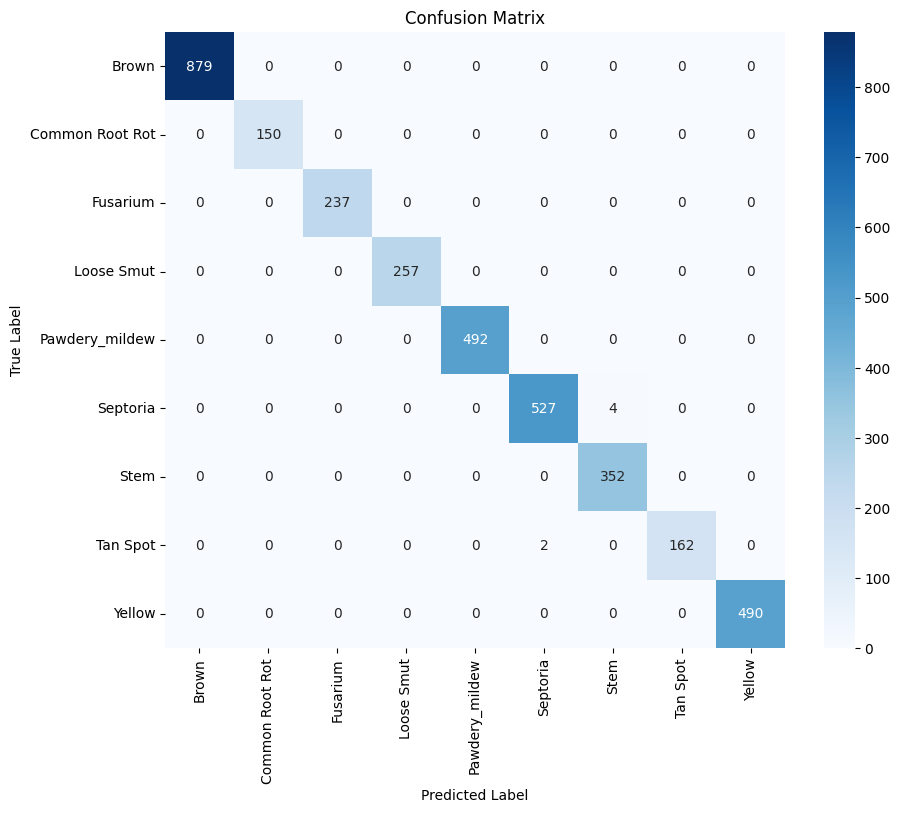

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score


# TESTING FUNCTION

def test(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  

    all_preds = []
    all_labels = []

    with torch.no_grad(): 
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Get predictions
            _, preds = torch.max(outputs, 1)  # Get class with highest probability

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average="macro")  
    f1 = f1_score(all_labels, all_preds, average="macro") 

    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return cm, accuracy, recall, f1

# PLOT CONFUSION MATRIX

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# RUN TESTING

if __name__ == "__main__":
    cm, test_accuracy, test_recall, test_f1 = test(model, test_loader)
    plot_confusion_matrix(cm, classes)


Top 3 classes prédictes :
1. Tan Spot: 0.8539
2. Septoria: 0.0534
3. Pawdery_mildew: 0.0263


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


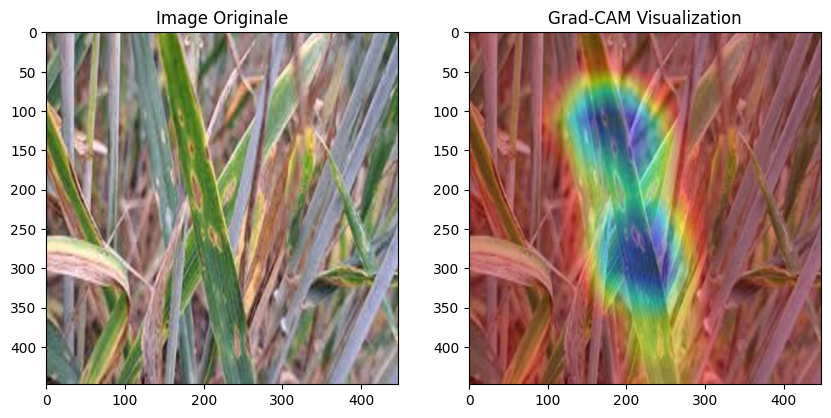

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch.nn.functional as F

model = CropDiseaseModel(num_classes=len(classes))  
model.load_state_dict(torch.load("M2_ECA.pth", map_location=torch.device("cpu")))
model.eval()

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.CenterCrop((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_path = "test.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0) 

output = model(input_tensor)
probabilities = torch.nn.functional.softmax(output, dim=1)  

top3_prob, top3_indices = torch.topk(probabilities, 3)

print("Top 3 classes prédictes :")
for i in range(3):
    class_name = classes[top3_indices[0][i].item()]
    probability = top3_prob[0][i].item()
    print(f"{i+1}. {class_name}: {probability:.4f}")

predicted_class = top3_indices[0][0].item()  

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Hook pour capturer les gradients
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activation_maps = output  # Sauvegarde des activations

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # Sauvegarde des gradients

    def generate_heatmap(self, input_tensor, target_class):
        # Faire une passe avant
        output = self.model(input_tensor)
        self.model.zero_grad()

        # Calculer le gradient de la classe cible
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot)

        # Moyenne des gradients
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        heatmap = torch.sum(weights * self.activation_maps, dim=1).squeeze()

        # Appliquer ReLU et normaliser
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)

        return heatmap.detach().cpu().numpy()

target_layer = model.backbone.layer4[-1]  
grad_cam = GradCAM(model, target_layer)

heatmap = grad_cam.generate_heatmap(input_tensor, predicted_class)

heatmap = cv2.resize(heatmap, (448, 448))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

image_np = np.array(image.resize((448, 448)))
superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Image Originale")

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Visualization")

plt.show()



Top 3 classes prédictes :
1. Pawdery_mildew: 0.9257
2. Fusarium: 0.0163
3. Yellow: 0.0160


c:\Users\DELL\intelpython3\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


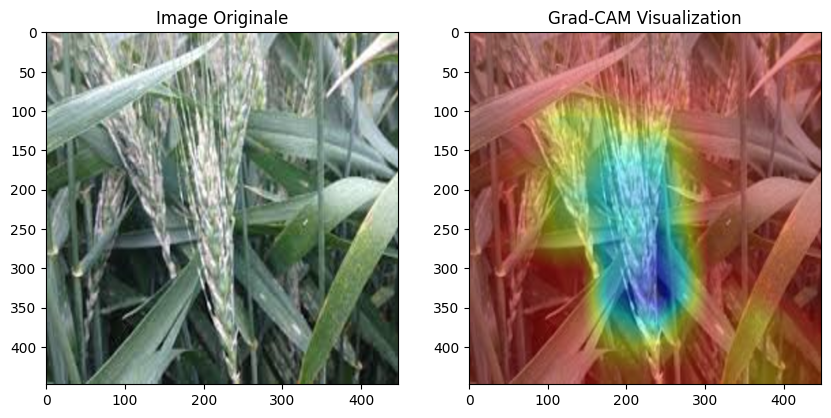

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch.nn.functional as F

Smodel = CropDiseaseModel(num_classes=len(classes)) 
model.load_state_dict(torch.load("M2_ECA.pth", map_location=torch.device("cpu")))
model.eval()

# Transformer l'image pour le modèle
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.CenterCrop((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Charger l'image de test
image_path = "test.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)  

output = model(input_tensor)
probabilities = torch.nn.functional.softmax(output, dim=1) 

# Obtenir les 3 classes avec les probabilités les plus élevées
top3_prob, top3_indices = torch.topk(probabilities, 3)

# Afficher les classes et probabilités correspondantes
print("Top 3 classes prédictes :")
for i in range(3):
    class_name = classes[top3_indices[0][i].item()]
    probability = top3_prob[0][i].item()
    print(f"{i+1}. {class_name}: {probability:.4f}")

# Utiliser la classe avec la plus haute probabilité pour Grad-CAM
predicted_class = top3_indices[0][0].item()  # ✅ Fix: Now we define predicted_class

### 📌 Grad-CAM Implementation ###
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Hook pour capturer les gradients
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activation_maps = output  # Sauvegarde des activations

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # Sauvegarde des gradients

    def generate_heatmap(self, input_tensor, target_class):
        # Faire une passe avant
        output = self.model(input_tensor)
        self.model.zero_grad()

        # Calculer le gradient de la classe cible
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot)

        # Moyenne des gradients
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        heatmap = torch.sum(weights * self.activation_maps, dim=1).squeeze()

        # Appliquer ReLU et normaliser
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)

        return heatmap.detach().cpu().numpy()

# Sélectionner la dernière couche de convolution du modèle (ex: ResNet50)
target_layer = model.backbone.layer4[-1]  # Modifier selon votre modèle
grad_cam = GradCAM(model, target_layer)

# Générer la carte de chaleur Grad-CAM pour la classe la plus probable
heatmap = grad_cam.generate_heatmap(input_tensor, predicted_class)

# Superposer sur l'image originale
heatmap = cv2.resize(heatmap, (448, 448))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Convertir l'image originale en NumPy
image_np = np.array(image.resize((448, 448)))
superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

# Afficher les résultats
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Image Originale")

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Visualization")

plt.show()

